## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [56]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [57]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [58]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [59]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [60]:
# quick way to get broadband power in time-varying windows
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [61]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

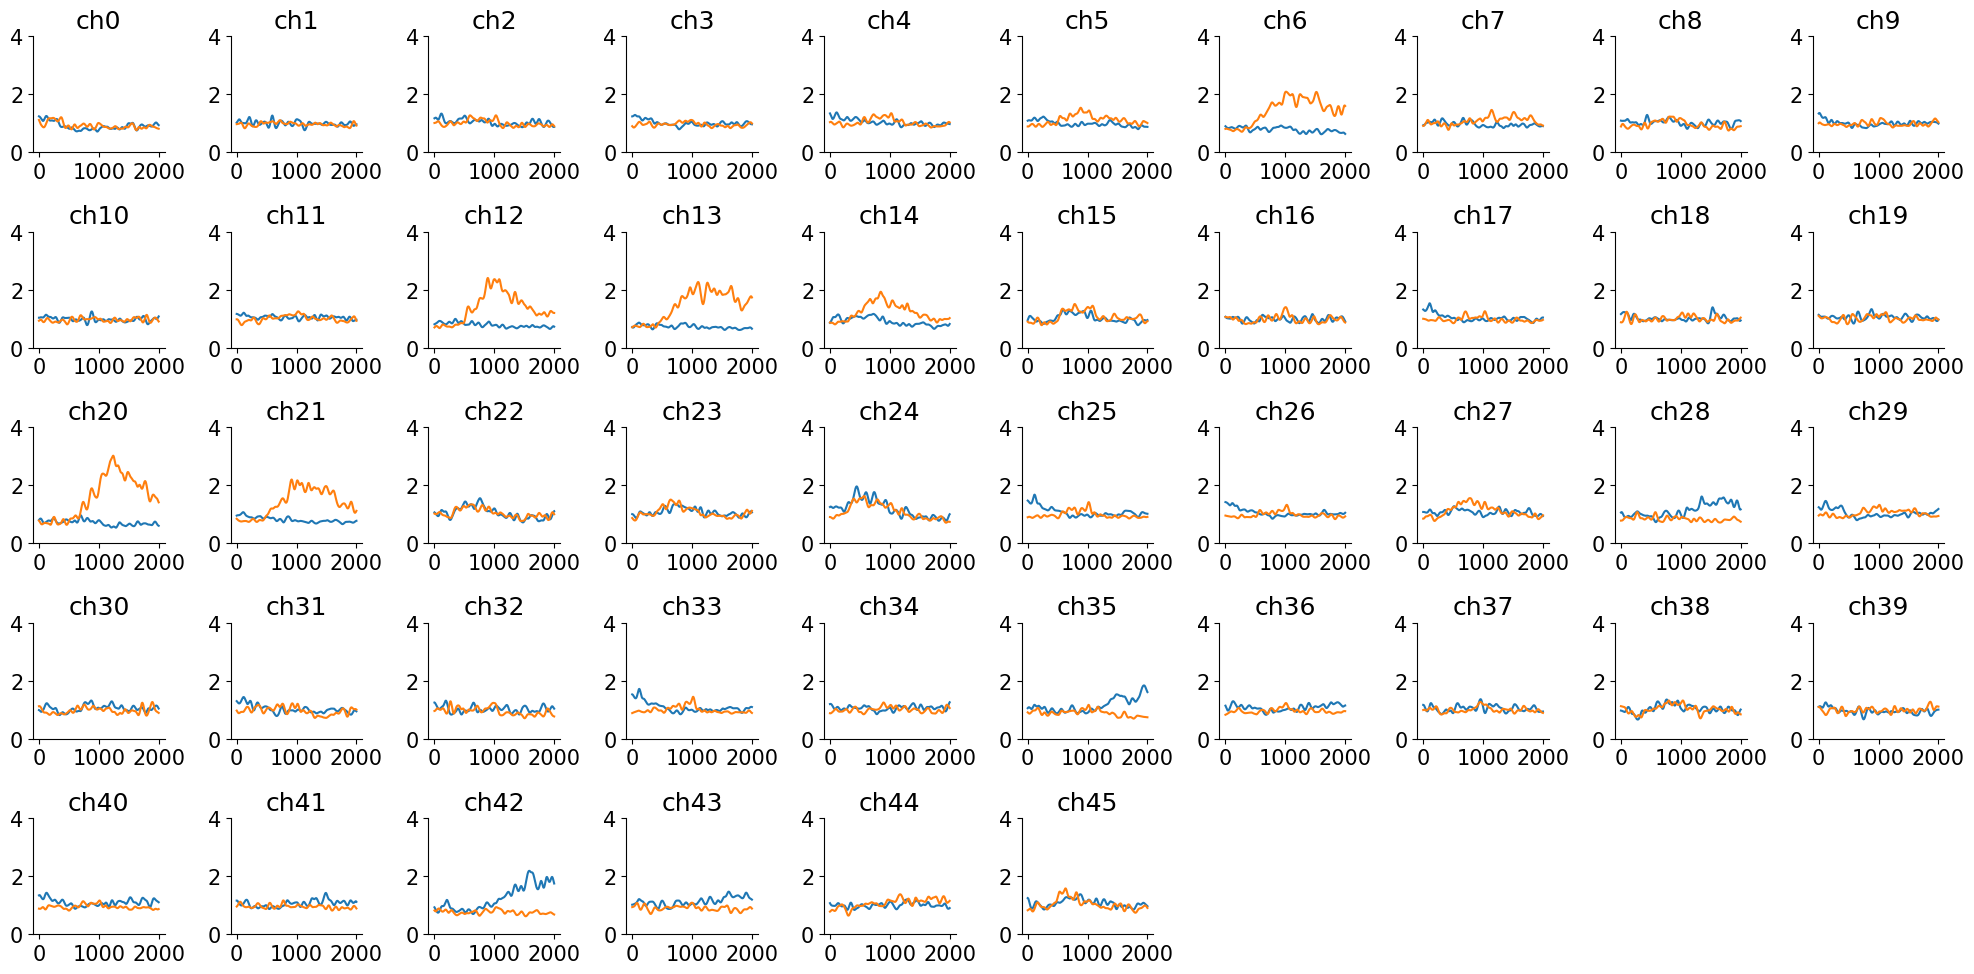

In [62]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
plt.show()

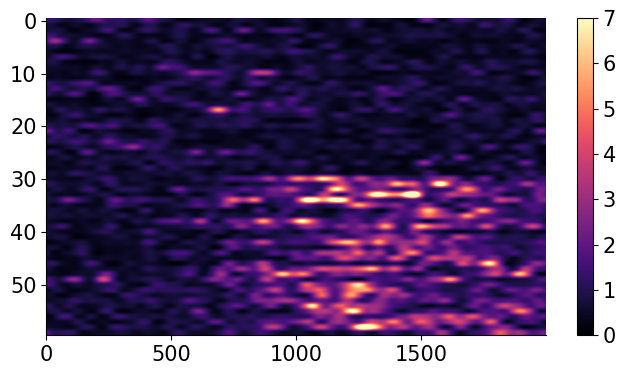

In [63]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

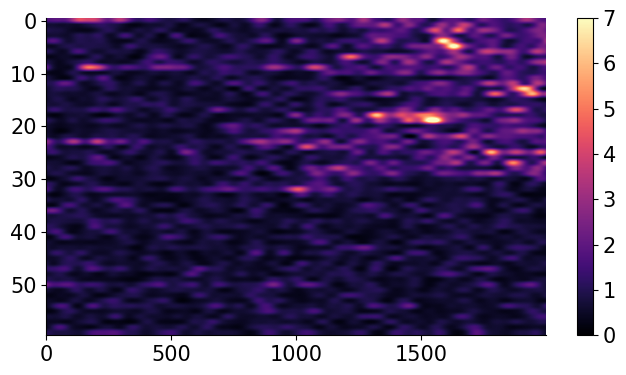

In [64]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 42].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [65]:
#@title Load data and define variables
# Load voltage dataset

# Define variables
# Voltage data: times x channel
V = dat1['V']
n_t, n_ch = V.shape
channels = np.arange(n_ch)
# Times
srate = dat1['srate']#.squeeze()
t_all = np.arange(n_t) #/ srate
t_on = dat1['t_on'] #/ srate
t_off = dat1['t_off'] #/ srate
# print("Min and max time / s:", t_all.min(), t_all.max())
# Stimulus identities
n_stim = len(t_on)
stim_id = dat1['stim_id']
n_stim_id = stim_id.max() - stim_id.min()
# 1-50 for houses, 51-100 for faces
n_stim_g =n_stim_id//2 + 1
id_max_house = 50

<ipython-input-66-c9100a083537>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks()*1e-3))


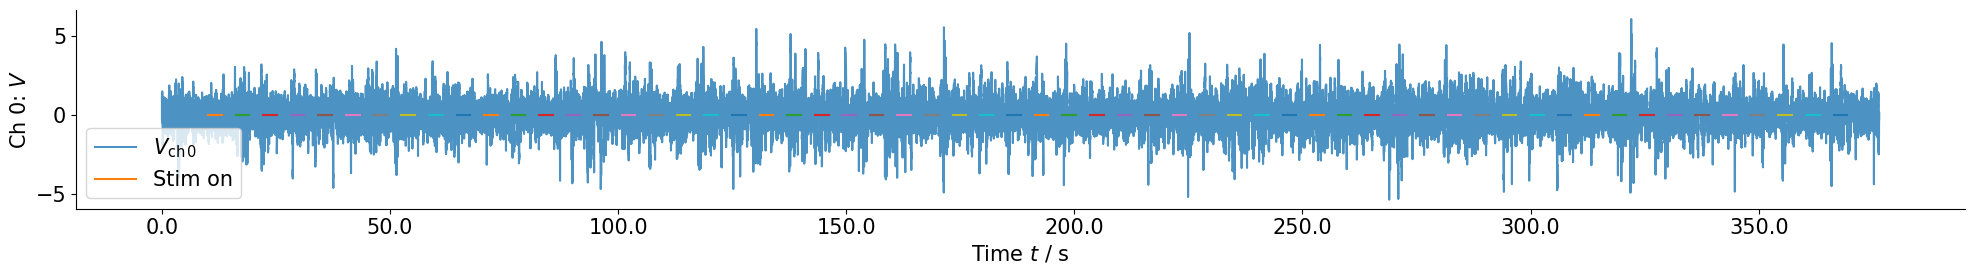

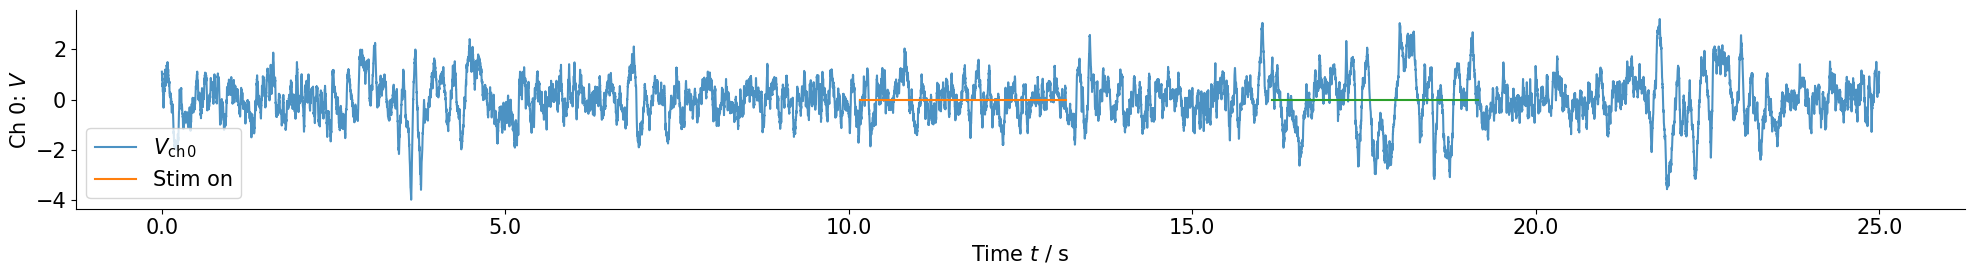

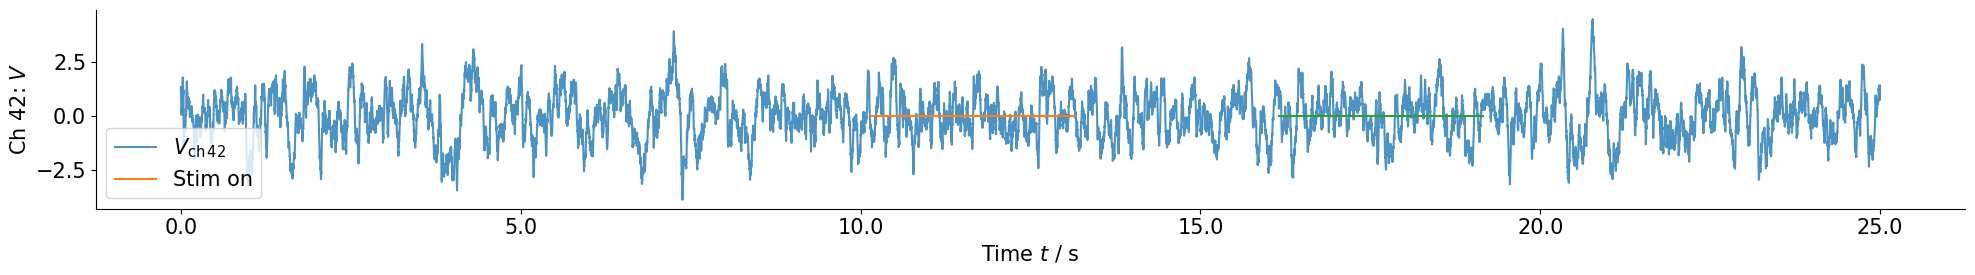

In [66]:
#@title Plot single channels
def plot_one_channel(i_ch=42, t_min_show=0, t_max_show=25e3):   # you can change the channel number here
    """ Plot all the data for one channel."""
    fig = plt.figure(figsize=(20, 3))
    ax = fig.subplots(1, 1)

    # Choose time window
    if t_min_show is None:
        t_min_show = t_all[0]
    if t_max_show is None:
        t_max_show = t_all[-1]
    mask = (t_all >= t_min_show) * (t_all < t_max_show)
    mask_oo = (t_on >= t_min_show) * (t_off < t_max_show)

    ax.plot(t_all[mask], V[mask][:, i_ch], alpha=0.8,
            label="$V_{\mathrm{ch}\,%d}$" %(i_ch))
    # Add stimulus on-off
    for i_t, (t_on_i, t_off_i) in enumerate(
        zip(t_on[mask_oo], t_off[mask_oo])):
        t_oo = np.array([t_on_i, t_off_i])
        ax.plot(t_oo, np.zeros_like(t_oo),
                label="Stim on" if i_t==0 else None)
    ax.legend(loc=3)
    ax.set_xticklabels((ax.get_xticks()*1e-3))
    ax.set_xlabel('Time $t$ / s')
    ax.set_ylabel('Ch %d: $V$' % i_ch)

plot_one_channel(i_ch=0, t_max_show=None)
plot_one_channel(i_ch=0)
plot_one_channel(i_ch=42)


In [67]:
import random
import matplotlib.pyplot as plt

# Define the number of colors you want to generate
num_colors = 50

# Generate a list of random colors
random_colors = []
for _ in range(num_colors):
    random_color = "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
    random_colors.append(random_color)

colors = random_colors

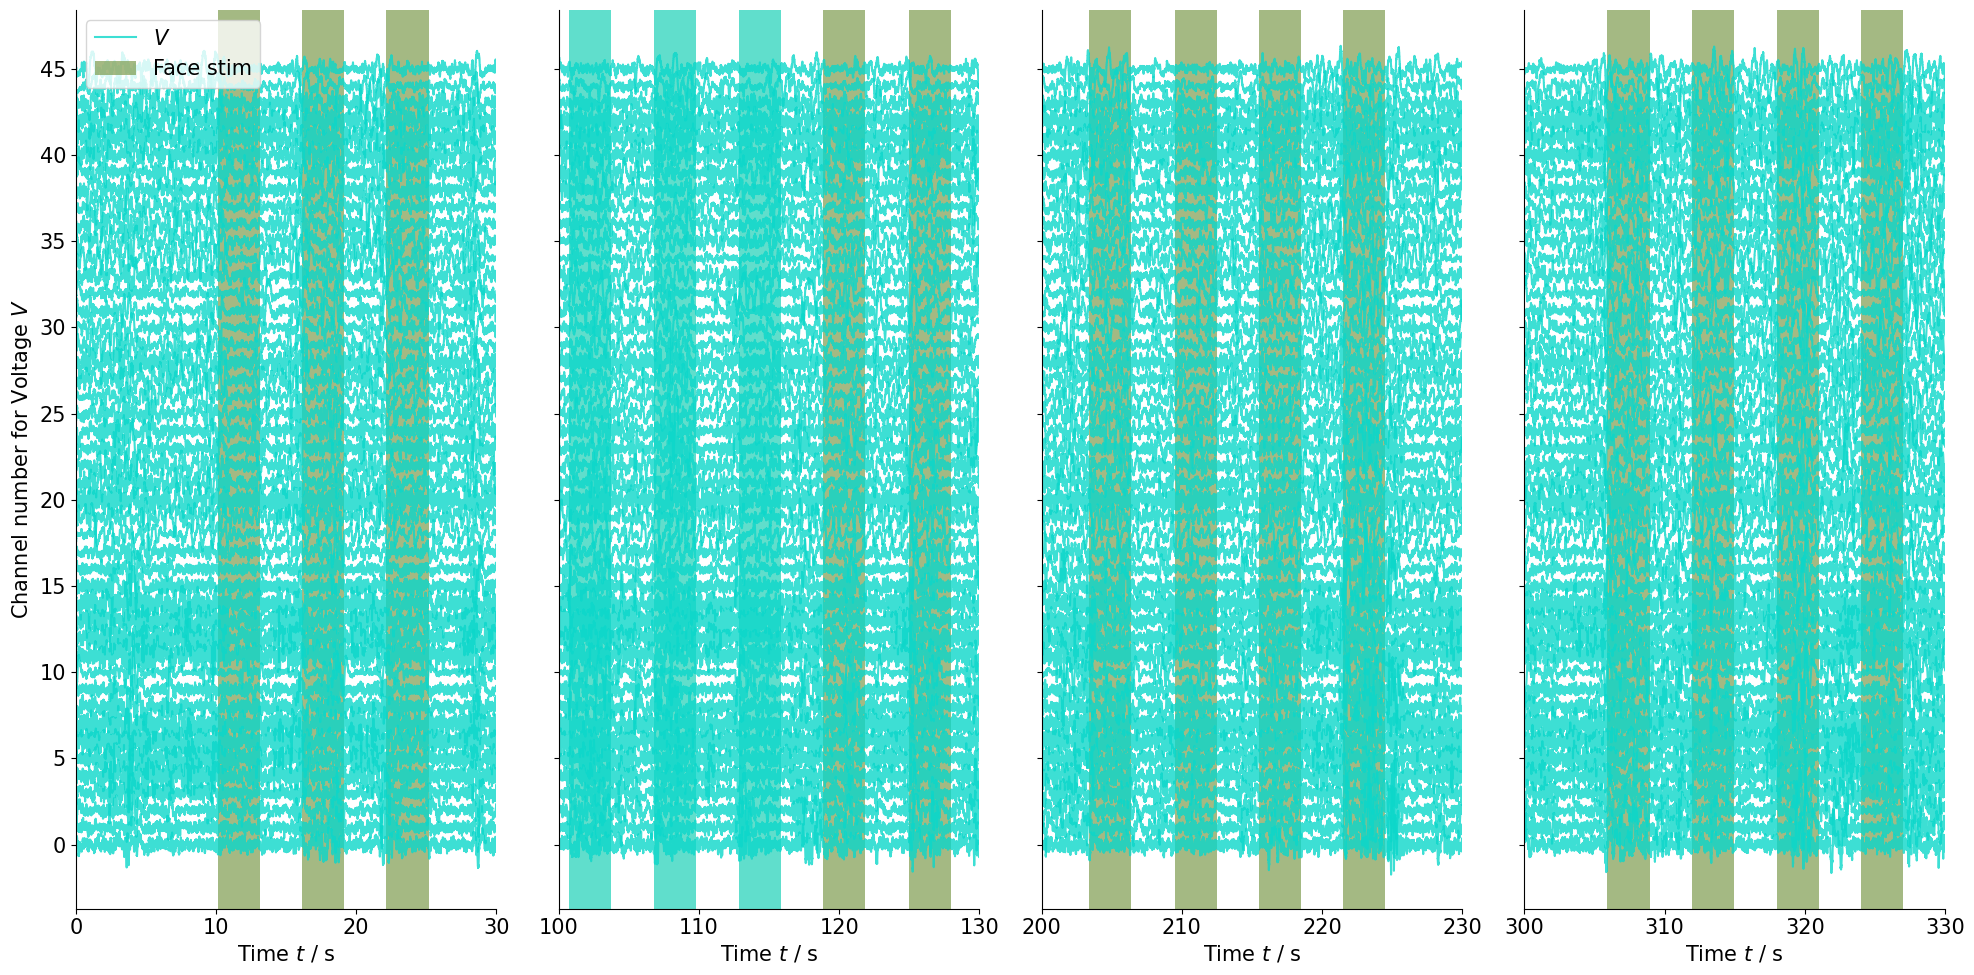

In [68]:
#@title Plot all channels
def plot_time_windows(ch_clusters=None):
    """ Plot smaller time windows, but all channels.
    """
    # Define 3 time windows in ms
    t_min_shows = np.array([0, 100, 200, 300]) * 1e3       # create an array of three time windows and their start times; convert time to millisecond
    dt = 30 * 1e3                                     # duration of each time window
    t_max_shows = t_min_shows + dt                    # create an array of three time windows and their end times
    n_t_show = len(t_min_shows)                       # this is the total number of time windows for the plot

    fig = plt.figure(figsize=(20, 10))
    n_cols = n_t_show
    axes = fig.subplots(1, n_t_show)                   # create 3 subplots in a 1 x n_t_show grid
    for i_c in range(n_t_show):
        ax = axes[i_c]
        # Choose time to be shown
        t_min_show = t_min_shows[i_c]
        t_max_show = t_max_shows[i_c]
        mask = (t_all >= t_min_show) * (t_all < t_max_show)     # mask indicates which data points are within the time window
        mask_oo = (t_on >= t_min_show) * (t_off < t_max_show)   # this indicates which data points are within the onset and offset windows

        # Show voltage traces
        offset = 3                                        # this is just the spacing between voltage traces in the plot
        if ch_clusters is None:                           # clustering is done in later cells (see below), so only voltage traces of all channels are plotted
            n_ch_show = n_ch
            for i_ch in range(n_ch_show):
                ax.plot(t_all[mask], V[mask, i_ch] + i_ch * offset, c=colors[0], alpha=0.8,
                        label="$V$" if i_ch==0 else None)
        else:
            # Sorted traces by clusters
            V_off = 0
            tickloc = []
            ticklbl = []
            for i_cl, ch_cluster in enumerate(ch_clusters):
                lbl_V = True
                c = colors[i_cl]
                for i_ch in ch_cluster:
                    lbl = r"$V_{\mathrm{Cluster %d}}$" % (i_cl) if lbl_V else None
                    lbl_V = False
                    ax.plot(t_all[mask], V[mask, i_ch] + V_off, c=c, alpha=0.8,
                            label=lbl)
                    tickloc.append(V_off)
                    ticklbl.append(i_ch)

                    V_off += offset
                V_off += 2 * offset

        # Show stimuli.
        # For this, we shade the times when a stimulus is on. Use a color scheme
        # to identify the stimulus.
        lbl_h = True
        lbl_f = True
        for i_t, (t_on_i, t_off_i) in enumerate(
            zip(t_on[mask_oo], t_off[mask_oo])):
            idx = np.where(dat1['t_on'] == t_on_i)[0][0]
            is_house = stim_id[idx] == 11
            # Color indicates stimulus id:
           # Color indicates stimulus id:
            if is_house:
                lbl = 'House stim' if lbl_h else None
                lbl_h = False
            else:
                lbl = 'Face stim' if lbl_f else None
                lbl_f = False

            if ch_clusters is None:
                hatch = None
                c = colors[1] if is_house else colors[2]
            else:
                c = '0.5'
                hatch = "///" if is_house else "\\"
            ax.axvspan(t_on_i, t_off_i, facecolor=c, hatch=hatch,
                       edgecolor='k', lw=0,
                       alpha=0.7, zorder=-1, label=lbl)
        # Some polishing
        if i_c == 0:
            ax.legend(loc=2)
        # y-axis
        if i_c == 0:
            ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax)
        if ch_clusters is None:
            ytl = np.arange(0, n_ch_show, 5)
            ax.set_yticks(ytl*offset)
            if i_c == 0:
                ax.set_yticklabels(ytl)
                ax.set_ylabel('Channel number for Voltage $V$')
            else:
                ax.set_yticklabels([])
        else:
            if i_c == 0:
                ax.set_ylabel('Clustered voltage channels')
                ax.set_yticks(tickloc)
                ax.set_yticklabels(ticklbl, fontsize=11)
            else:
                ax.set_yticklabels([])
        # x-axis
        ax.set_xlim(t_min_show, t_max_show)
        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_xticklabels(np.int_(xticks*1e-3))
        ax.set_xlabel('Time $t$ / s')
plot_time_windows()


'egnpairs = [(np.abs(egnvalues[i]), egnvectors[:, i])\n                for i in range(len(egnvalues))]\negnpairs.sort(key=lambda k: k[0], reverse=True)\nprojectionMatrix = np.hstack((egnpairs[0][1][:, np.newaxis],\n                              egnpairs[1][1][:, np.newaxis],\n                              egnpairs[2][1][:, np.newaxis],\n                              egnpairs[3][1][:, np.newaxis],\n                              egnpairs[4][1][:, np.newaxis]))\nprint(projectionMatrix)'

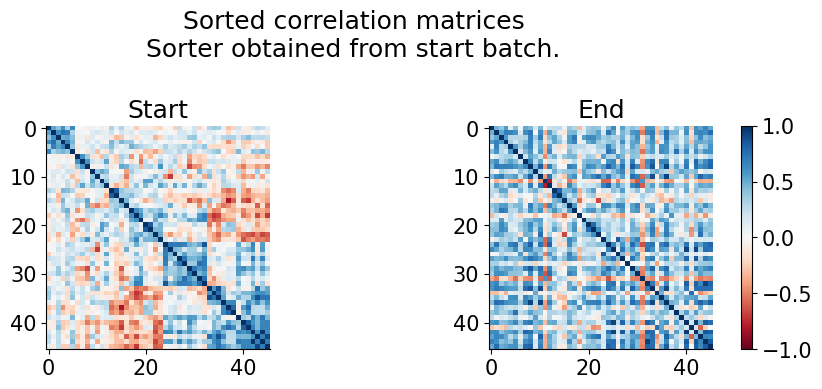

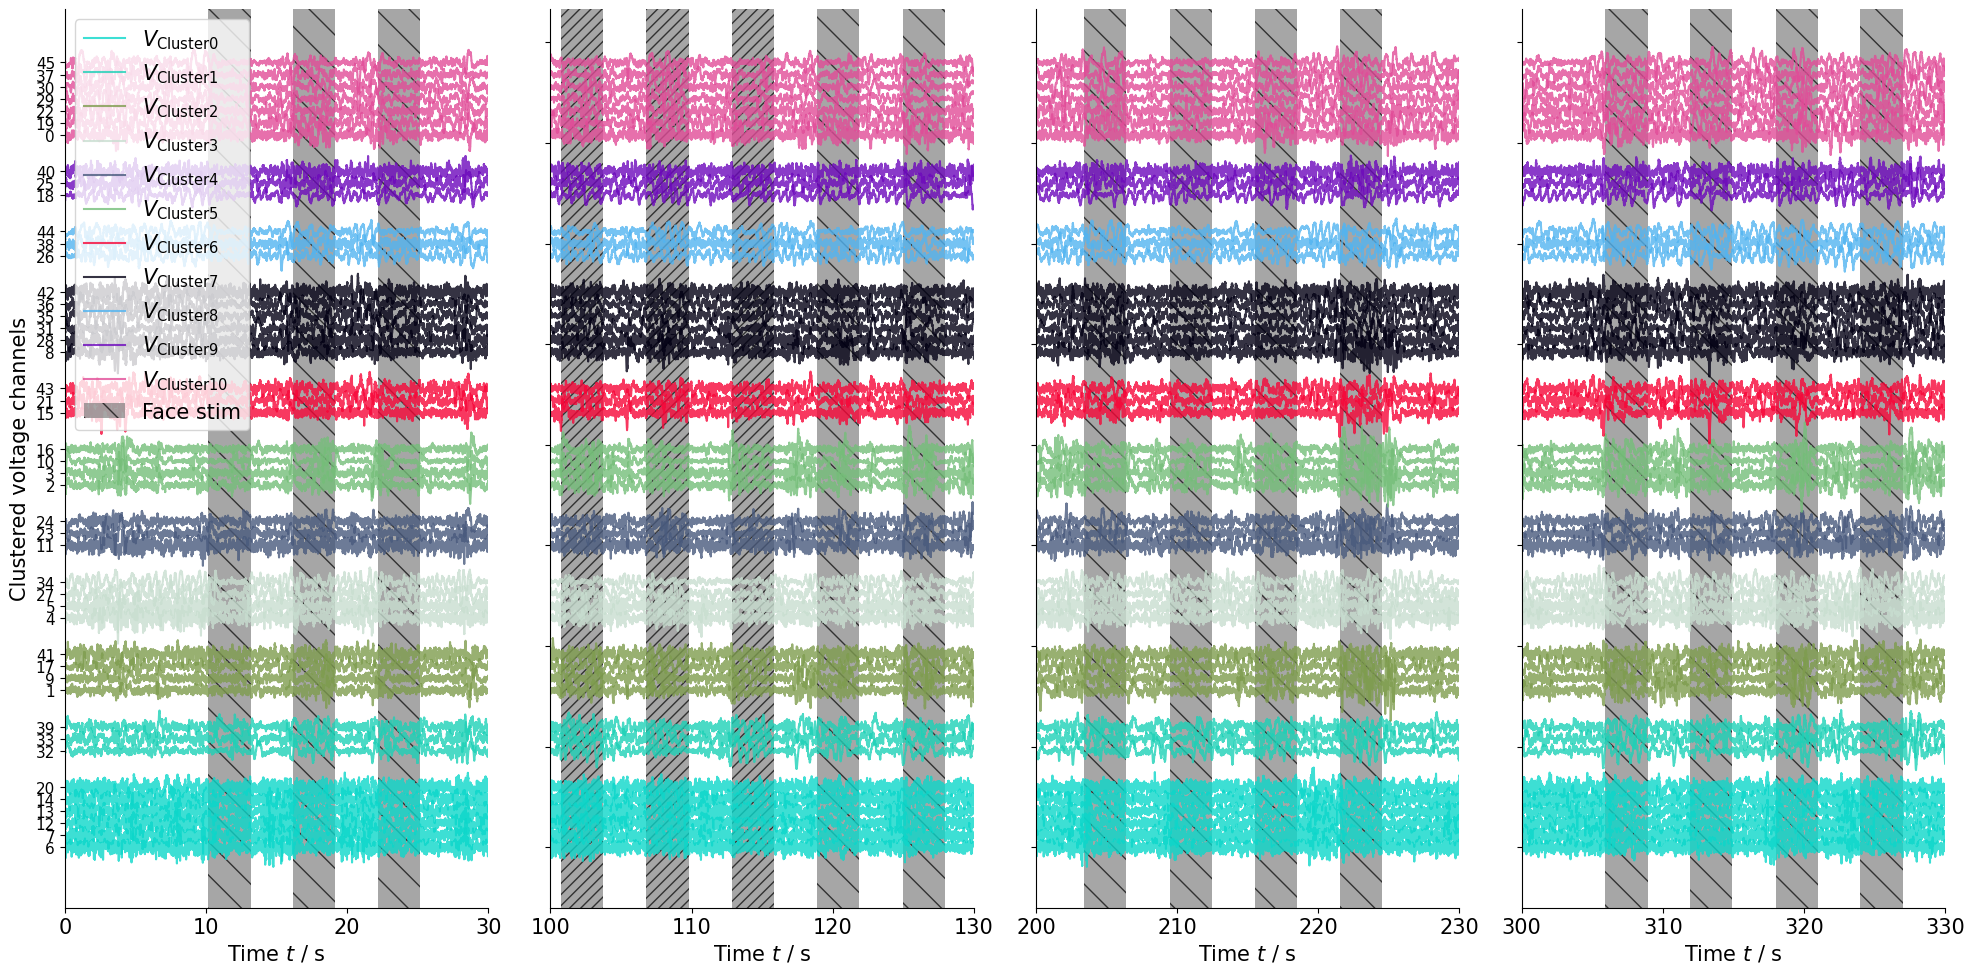

In [69]:
#@title Cluster channels with cross correlation

# Subsampling for ease on memory?
step = 10         # this subsamples the data in a step size of 10

# Choose time window (restrict analysis to a specific time period)
dt = 400
t_mins = np.array([t_on[0], t_off[-1]-dt])
t_maxs = t_mins + dt
n_cov = len(t_mins)

corr_all = np.zeros((n_cov, n_ch, n_ch))
for i_c in range(n_cov):                  # loop through time windows
    t_min = t_mins[i_c]                   # for each time window, get the start and end times
    t_max = t_maxs[i_c]
    mask = (t_all >= t_min) * (t_all < t_max)   # mask to indicate which data points are within the time window
    Vw = np.float_(V[mask][::step])             # data is subsampled using step=10
    Vw_sq = (Vw**2).sum(0)                      # calculate the variance of the data
    cov = (Vw[:, :, None] * Vw[:, None, :]).sum(0)      # calculate the covariance of the data. Covariance is a measure of how similar two signals are
    corr = cov / np.sqrt(Vw_sq[:, None] * Vw_sq[None, :])   # calculate the correlation. Correlation is covariance normalized by the variance of the signal
    corr_all[i_c] = corr                        # 2D array stores correlation data; time window x stim ID

# Cluster channels according to correlation
# Use the first matrix to cluster (first time window; training set); the second is for validation (second time window; test set)
# If the two matrices look similar, then the clustering is robust
corr = corr_all[0]

# Sort matrix by clusters.
# Based on: https://wil.yegelwel.com/cluster-correlation-matrix/
import scipy
import scipy.cluster.hierarchy as sch                 # this library has functions for hierarchical clustering
pairwise_distances = sch.distance.pdist(corr)         # the distance between two channels is a measure of how similar the channels are
linkage = sch.linkage(pairwise_distances, method='complete')      # linkage matrix is a hierarchical clustering of channels
cluster_distance_threshold = pairwise_distances.max()/2           # this threshold determines which channels belong in the same cluster
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                    criterion='distance')         # this array indicates which cluster each channel belongs to
cl_sorter = np.argsort(idx_to_cluster_array)                      # channels are sorted according to cluster using cluster ID
# Obtain channel ids in each cluster
clusters = np.unique(idx_to_cluster_array)                        # loop through the unique cluster IDs
ch_clusters = []
for cl in clusters:                                               # for each cluster ID, get channel IDs that belong to each cluster
    cl_idx = np.where(idx_to_cluster_array == cl)[0]
    ch_clusters.append(channels[cl_idx])
n_cl = len(ch_clusters)                                           # 2D list (cluster ID, channel ID)

# Plot clustering
fig = plt.figure(figsize=(10, 4))
axes = fig.subplots(1, n_cov)
for i_c in range(n_cov):
    ax = axes[i_c]
    corr = corr_all[i_c]
    corr_s = corr[cl_sorter, :][:, cl_sorter]
    im = ax.imshow(corr_s, cmap="RdBu", vmin=-1, vmax=1)
    if i_c == n_cov-1:
        plt.colorbar(im)
    lbl = ["Start", "End"][i_c]
    ax.set_title(lbl)
fig.suptitle("Sorted correlation matrices\nSorter obtained from start batch.")

plot_time_windows(ch_clusters)

### eigh calculation
from numpy.linalg import eigh

egnvalues, egnvectors = eigh(cov)
#
# Determine explained variance and select the most important eigenvectors based on explained variance
#
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]
#
# Construct projection matrix using the five eigenvectors that correspond to the top five eigenvalues (largest), to capture about 75% of the variance in this dataset
#
'''egnpairs = [(np.abs(egnvalues[i]), egnvectors[:, i])
                for i in range(len(egnvalues))]
egnpairs.sort(key=lambda k: k[0], reverse=True)
projectionMatrix = np.hstack((egnpairs[0][1][:, np.newaxis],
                              egnpairs[1][1][:, np.newaxis],
                              egnpairs[2][1][:, np.newaxis],
                              egnpairs[3][1][:, np.newaxis],
                              egnpairs[4][1][:, np.newaxis]))
print(projectionMatrix)'''

<ipython-input-70-029882f766cd>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks()*1e-3))


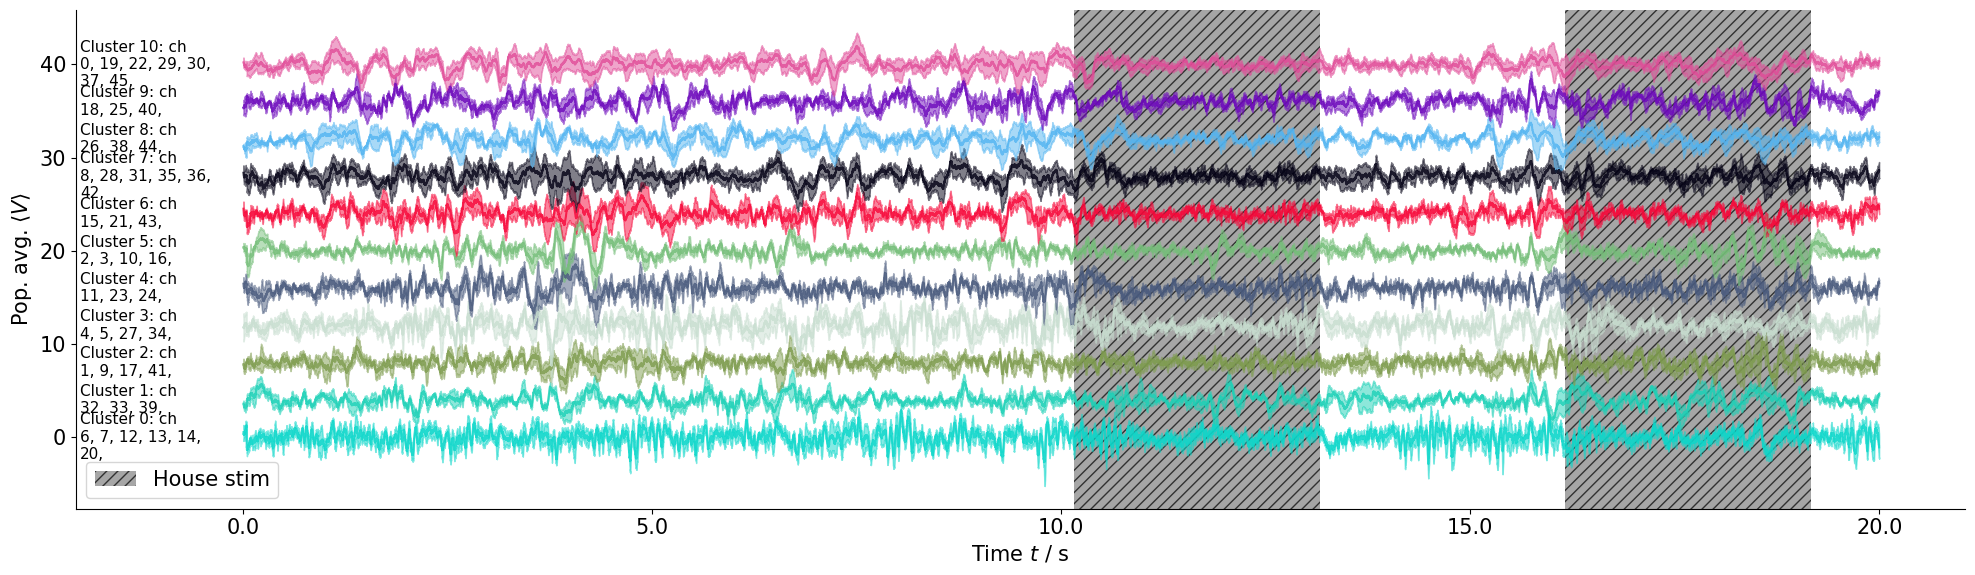

In [70]:
#@title Plot cluster averages
def plot_pop_avg(t_min_show=0, t_max_show= 40 * 1e3, ch_clusters=None):
    if ch_clusters is None:
        fig = plt.figure(figsize=(20, 3))
    else:
        fig = plt.figure(figsize=(20, 6))
    ax = fig.subplots(1, 1)
    # Choose time window
    mask = (t_all >= t_min_show) * (t_all < t_max_show)
    mask_oo = (t_on >= t_min_show) * (t_off < t_max_show)

    if ch_clusters is None:
        V_cl = V[mask]
        V_clm = V_cl.mean(1)
        V_cls = V_cl.std(1)
        ax.plot(t_all[mask], V_clm, alpha=0.8,
                label=r"$\langle V\rangle$")
        ax.fill_between(t_all[mask], V_clm - V_cls, V_clm + V_cls,
                        alpha=0.5)
    else:
        # Sorted traces by clusters
        offset = 4
        for i_cl, ch_cluster in enumerate(ch_clusters):
            c = colors[i_cl]
            V_off = offset * i_cl
            V_cl = V[mask][:, ch_cluster] + V_off
            V_clm = V_cl.mean(1)
            V_cls = V_cl.std(1)
            ax.plot(t_all[mask], V_clm, c=c, alpha=0.8)
            ax.fill_between(t_all[mask], V_clm - V_cls, V_clm + V_cls,
                            color=c, alpha=0.5)
            # Indicate clusters
            lbl = "Cluster %d: ch\n" %i_cl
            for ii, i_ch in enumerate(ch_cluster):
                lbl += "%d, " % i_ch
                if ii %5 == 4: lbl += "\n"
            lbl = lbl[:-1]
            dt = (t_max_show - t_min_show)
            y = t_min_show - dt/10
            ax.text(y, V_off, lbl, ha='left', va='center', fontsize=11)
            ax.plot(t_min_show-dt/20, 0, '-')

    # Show stimuli.
    # For this, we shade the times when a stimulus is on. Use a color scheme
    # to identify the stimulus.
    lbl_h = True
    lbl_f = True
    for i_t, (t_on_i, t_off_i) in enumerate(
        zip(t_on[mask_oo], t_off[mask_oo])):
        # Color indicates stimulus id:
        is_house = stim_id[i_t] <= id_max_house
        if is_house:
            lbl = 'House stim' if lbl_h else None
            lbl_h = False
        else:
            lbl = 'Face stim' if lbl_f else None
            lbl_f = False

        if ch_clusters is None:
            hatch = None
            c = colors[1] if is_house else colors[2]
        else:
            c = '0.5'
            hatch = "///" if is_house else "\\"

        ax.axvspan(t_on_i, t_off_i, facecolor=c, hatch=hatch,
                   edgecolor='k', lw=0,
                   alpha=0.7, zorder=-1, label=lbl)

    ax.legend(loc=3)
    ax.set_xticklabels((ax.get_xticks()*1e-3))
    ax.set_xlabel('Time $t$ / s')
    ax.set_ylabel(r'Pop. avg. $\langle V \rangle$')

plot_pop_avg(0, 20e3, ch_clusters=ch_clusters)

Text(0.5, 0.98, 'PCA results for clusters (with # channels)\nIn a nutshell: signals are not low-D')

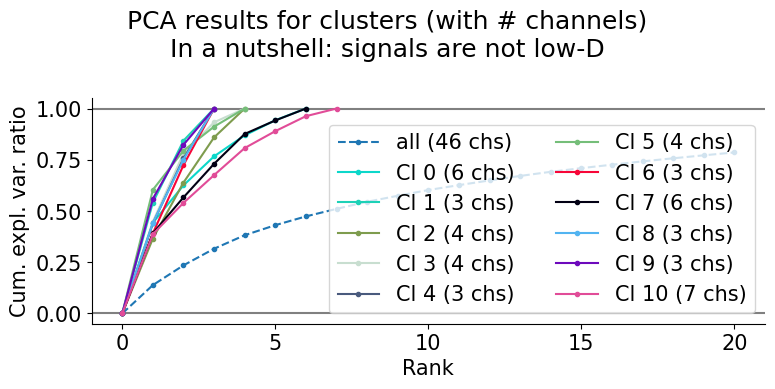

In [71]:
#@title PCA per cluster (not very informative)
from sklearn.decomposition import PCA
# Full PCA
n_comp = 20
pca = PCA(n_comp)
pca.fit(V)
cevr_V = pca.explained_variance_ratio_.cumsum()
cevr_V = np.r_[0, cevr_V]
rank = np.arange(len(cevr_V))

# PCA for each cluster
cevr_cl = np.zeros((n_cl, ), dtype=object)
for i_cl in range(n_cl):
    ch_cl = ch_clusters[i_cl]
    V_cl = V[:, ch_cl]
    n_comp_cl = min(n_comp, len(ch_cl))
    pca = PCA(n_comp_cl)
    pca.fit(V_cl)
    cevr_cl_i = pca.explained_variance_ratio_.cumsum()
    cevr_cl[i_cl] = np.r_[0, cevr_cl_i]

# Plot
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)
ax.plot(cevr_V, '.--', label="all (%d chs)" %(n_ch))
for i_cl in range(n_cl):
    c = colors[i_cl]
    n_ch_cl = len(ch_clusters[i_cl])
    ax.plot(cevr_cl[i_cl], '.-', c=c, label="Cl %d (%d chs)" % (i_cl, n_ch_cl))
ax.legend(loc=4, ncol=2)
ax.set_xticks(rank[::5])
ax.set_xlabel("Rank")
ax.set_ylabel("Cum. expl. var. ratio")
ax.axhline(0, c='0.5', zorder=-1)
ax.axhline(1, c='0.5', zorder=-1)
fig.suptitle("PCA results for clusters (with # channels)\nIn a nutshell: signals are not low-D")

